In [1]:
from collections import namedtuple
import hashlib
import os
from os.path import join as joinpath, exists as pathexists
import pickle
import sys
import warnings


from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import glob
import os

%matplotlib inline

In [39]:
results_dir='/home/samuel/data/drift_tool_test/salish_test_20170416/output/'
# Use glob to find all netcdf files in results_dir
files = glob.glob(os.path.join(results_dir, '*.nc'))

In [40]:
files

['/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-604_1491894016.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-602_1491901137.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-626_1491932630.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-125_1491883655.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-133_1491850385.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-615_1491972004.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017041900_P1D-612_1492006399.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishseacast_ar_2017042000_P1D-593_1492105641.nc',
 '/home/samuel/data/drift_tool_test/salish_test_20170416/output/salishse

In [41]:
""" Obtain a unique list from files that contains drifters with same observed unique id """
unique_list =[]
for file in files:
    # Open dataset
    ds = xr.open_dataset(file)
    drift_id = ds.obs_unique_id
    if drift_id not in unique_list:
        unique_list.append(drift_id)
    ds.close()
print(unique_list)

['604_1491894016', '602_1491901137', '626_1491932630', '125_1491883655', '133_1491850385', '615_1491972004', '612_1492006399', '593_1492105641', '606_1491906609', '132_1491850313']


In [51]:
 def plot_file(file_name,basemap,bbox):
    """Plot the modelled and observed trajector in a file fname 
     Parameters
     ----------
     file_name : File whose varibles and attributes will be used to plot the trajectories
     basemap : Basemap
             Basemap on which to plot the modelled and observed trajector
     bbox : LatLonBoundingBox
             Specifies the bounding box for the plot. It determines the coordinates for each drifter for accurate plotting 
    
    
    """
    # open dataset for driftes 
    ds = xr.open_dataset(file_name)
    
    basemap.drawcoastlines()
    
    # assign dataset variables for plotting
    x, y =basemap(ds.obs_lon.values, ds.obs_lat.values)
    j,k = basemap(ds.mod_lon.values, ds.mod_lat.values)
    basemap.plot(x, y, c='y', label='observations')
    basemap.plot(x[0], y[0], 'mo')
    basemap.plot(x[-1], y[-1], 'ro')
    
    # model trajectory plotted with scatter 
    cm = plt.cm.get_cmap('viridis')
    mesh =basemap.scatter(j, k,c=ds.sep.values,marker='o', s=15,vmin=0, vmax=10000,cmap=cm)
    c_bar =basemap.colorbar(mesh,location='bottom',pad="5%")
    c_bar.set_label('Modelled Trajectory', fontsize = 15)
    basemap.plot(j[0], k[0], 'mo')
    basemap.plot(j[-1], k[-1], 'ro')
    
    # fill continents, set lake color same as ocean color. 
    basemap.fillcontinents(color='white',lake_color='aqua')
    basemap.drawmapboundary(fill_color='aqua')
    plt.title('Drifter {}'.format(ds.obs_buoyid), fontsize = 15)
    
    # parallels and meriands for the maps
    dlat = (bbox.lat_max - bbox.lat_min)/3
    dlon = (bbox.lon_max - bbox.lon_min)/3
    parallels = np.arange(np.floor(bbox.lat_min), np.ceil(bbox.lat_max), dlat)
    basemap.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=9,
                             linewidth=0.5, color='0.5')
    meridians = np.arange(np.floor(bbox.lon_min), np.ceil(bbox.lon_max), dlon)
    basemap.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=9,
                             linewidth=0.5, color='0.5')
    
    ds.close()

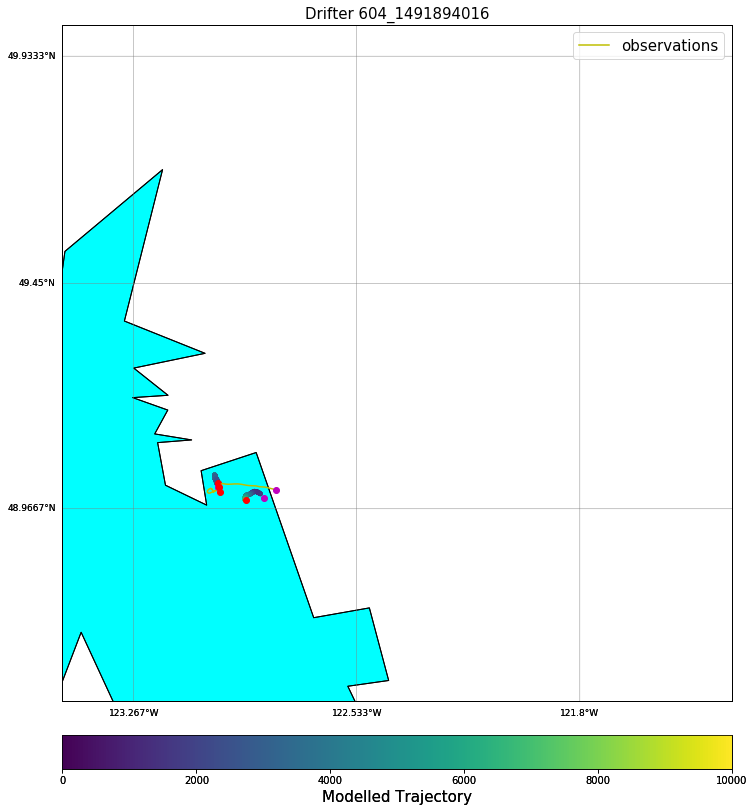

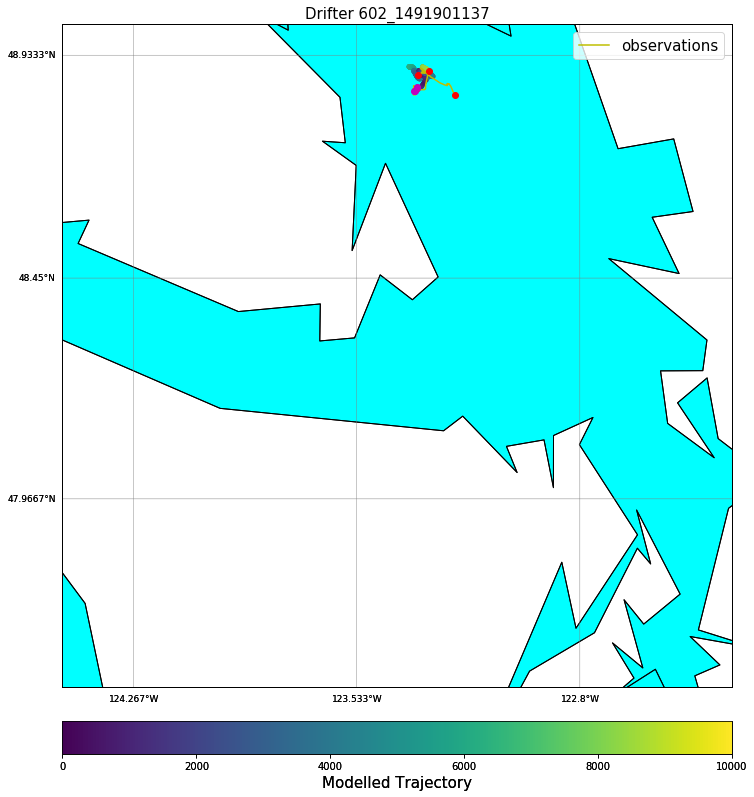

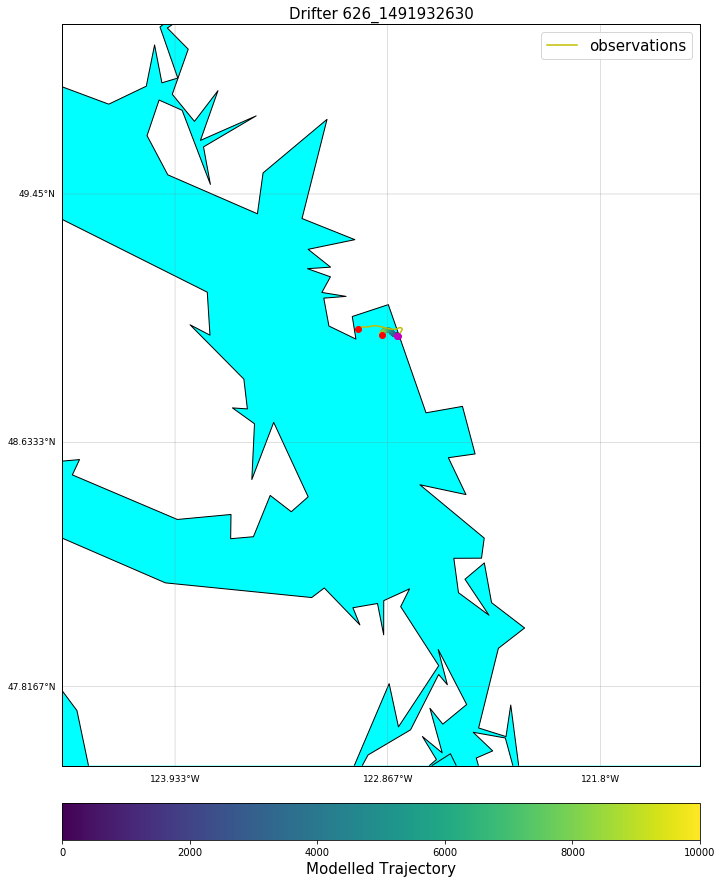

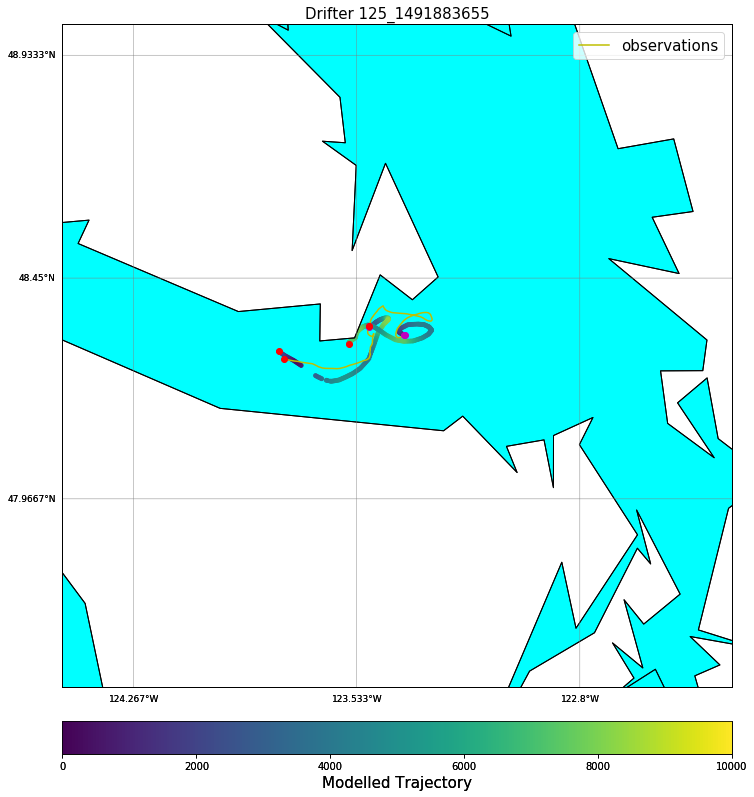

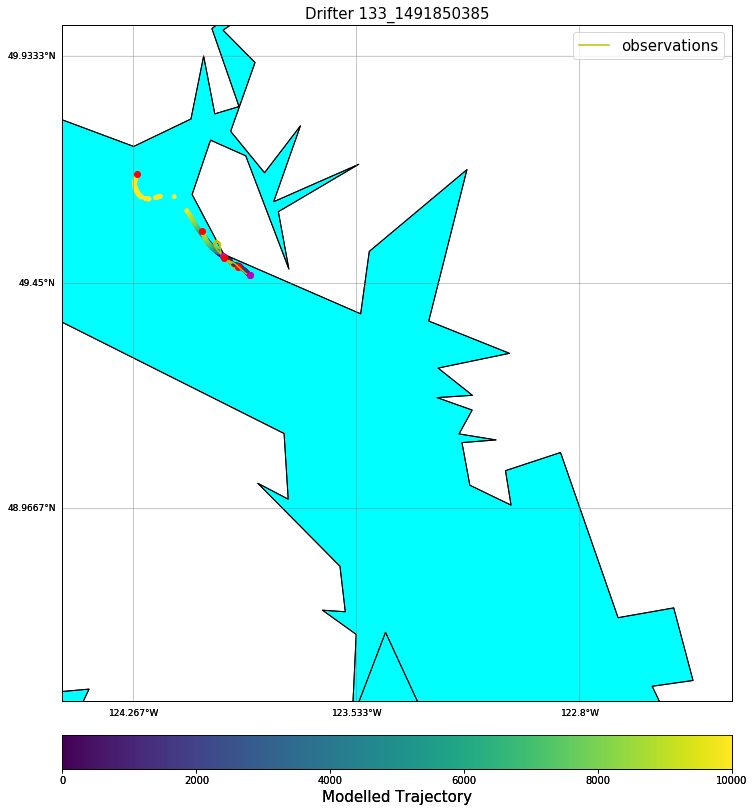

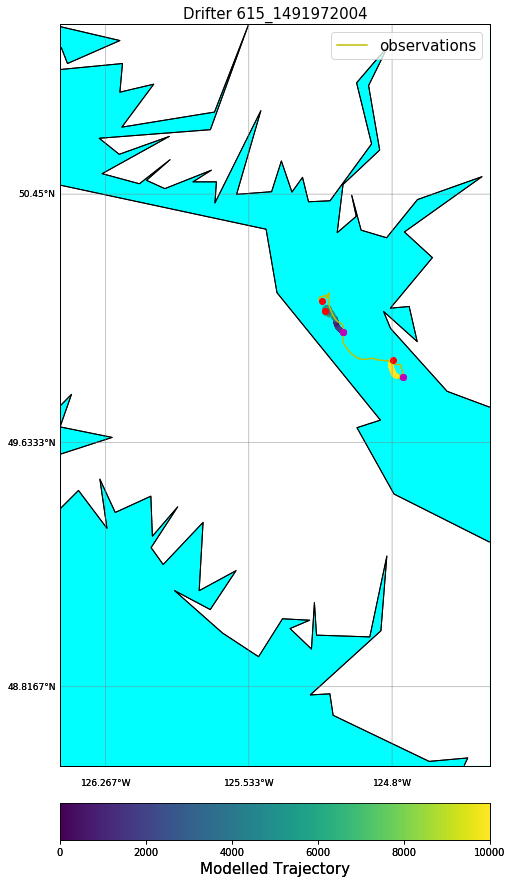

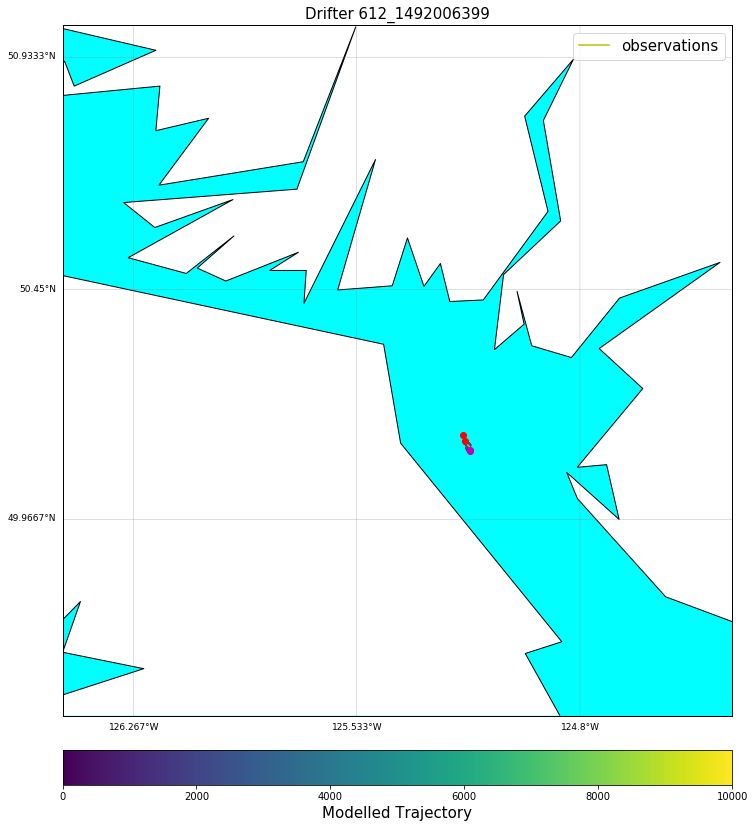

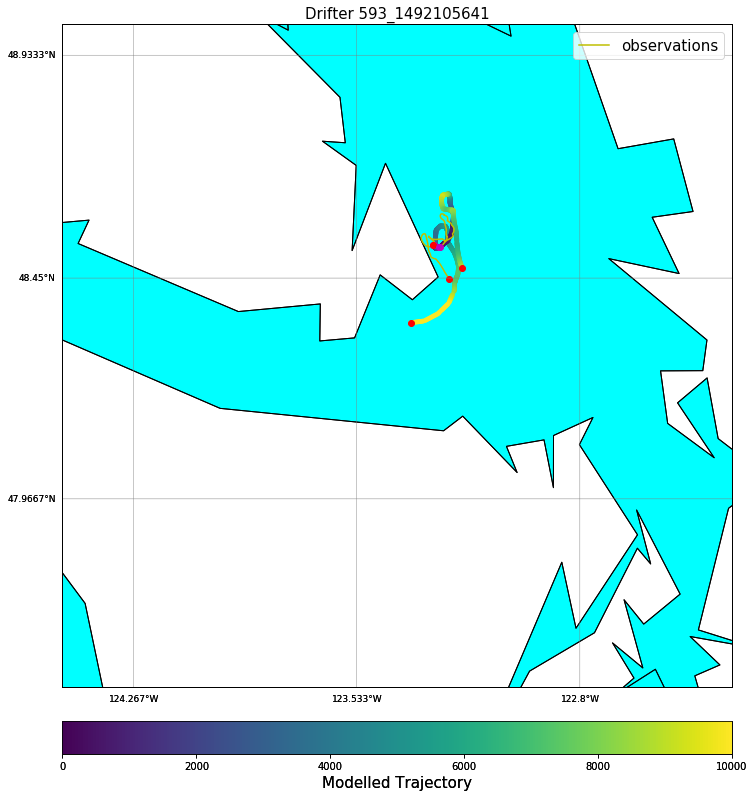

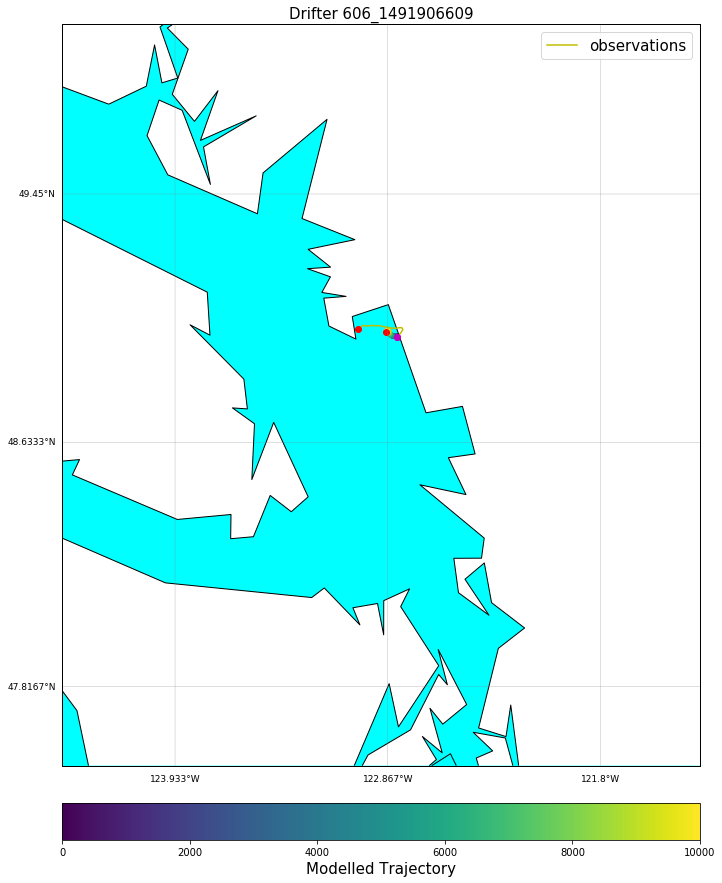

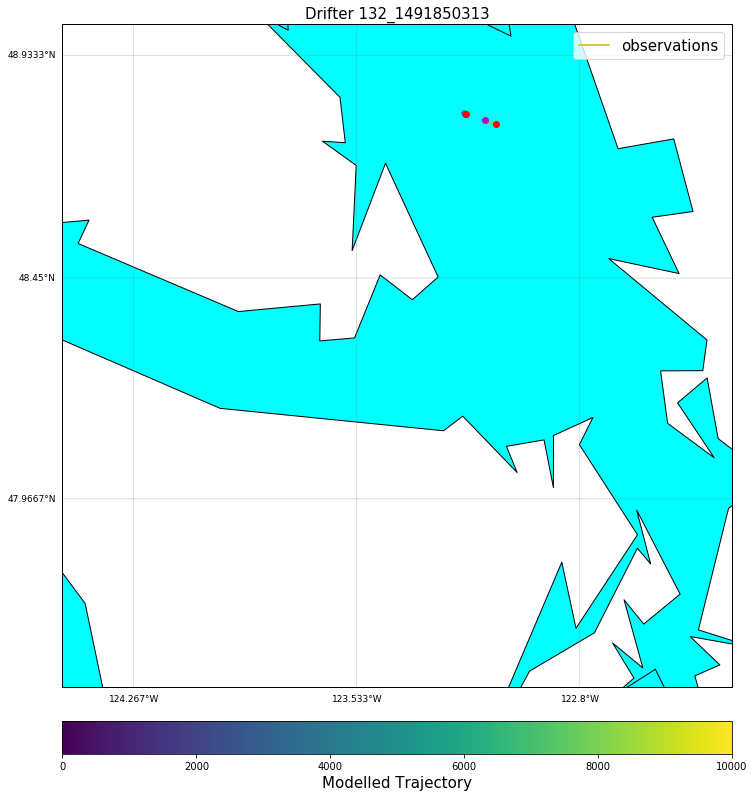

In [93]:
"""Run and display maps with the observed and modelled trajectory
     
     filelist : list of drifters with unique observed ids
     newFile : Get content of files to avoid overriding contents of files 
     map_features : function to plot map, set size and label of the map
"""

filelist = []
newFiles = files 
for num in unique_list:
    filename = '*{}.nc'.format(num)
    newFiles = glob.glob(os.path.join(results_dir, filename))
    filelist.append(newFiles)
    fig, ax = plt.subplots(1,1) 
    for file in newFiles:
        map_features(12,15,20)
        ds = xr.open_dataset(file)
        bbox = determine_latlon_bbox_for_drifters(ds)
    maplot = Basemap(projection='merc',resolution='l',llcrnrlon=bbox.lon_min,llcrnrlat=bbox.lat_min,
                     urcrnrlon=bbox.lon_max,urcrnrlat=bbox.lat_max)    
    for file in newFiles:
        plot_file(file,maplot,bbox)
        legends()

In [55]:
def map_features(length,breadth,labelsize):
    # ax.set_xlabel('Longitude', fontsize=labelsize)
    # ax.set_ylabel('Latitude', fontsize=labelsize)
    plt.rcParams['figure.figsize'] = [length, breadth]
    

In [78]:
"""Create legend for each plots and handle duplicated legends due to multipe unique observed id for all maps"""
def legends():
    # handle duplicated legends 
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list, fontsize=15,loc='upper right',)

In [85]:
LatLonBoundingBox = namedtuple('LatLonBoundingBox',
                               ('lat_min', 'lat_max', 'lon_min', 'lon_max'))
def determine_latlon_bbox_for_drifters(drifters):
    """Determine the latitude and longitude bounding box for drifter tracks.

    Parameters
    ----------
    drifters :Dataset
        List of drifter tracks. Each drifter must be ``an xarray.Dataset`` with
        the observed latitude and longitude from the dataset.

    Returns
    -------
    bbox : LatLonBoundingBox
    """
    # These initial values are outside the valid ranges for latitudes and
    # longitudes, and are guaranteed to change on the first loop below.
    lat_min = 1000.
    lon_min = 1000.
    lat_max = -1000.
    lon_max = -1000.
    for drifter in drifters:
        drifter_lat_min =drifters.obs_lat.values.min()
        drifter_lat_max =drifters.obs_lat.values.max()
        drifter_lon_min =drifters.obs_lon.values.min()
        drifter_lon_max =drifters.obs_lon.values.max()
        lat_min = min(drifter_lat_min, lat_min)
        lat_max = max(drifter_lat_max, lat_max)
        lon_min = min(drifter_lon_min, lon_min)
        lon_max = max(drifter_lon_max, lon_max)

    lat_min = np.floor(lat_min)
    lat_max = np.ceil(lat_max)
    lon_min = np.floor(lon_min)
    lon_max = np.ceil(lon_max)
    
    lon_min=lon_min - 0.50
    lat_min=lat_min - 0.45
    lon_max=lon_max + 0.70
    lat_max=lat_max
    
    return LatLonBoundingBox(lon_min=lon_min, lat_min=lat_min,
                             lon_max=lon_max, lat_max=lat_max)

llon -126.5 llat 48.55 ulo -124.3 ulat 51.0


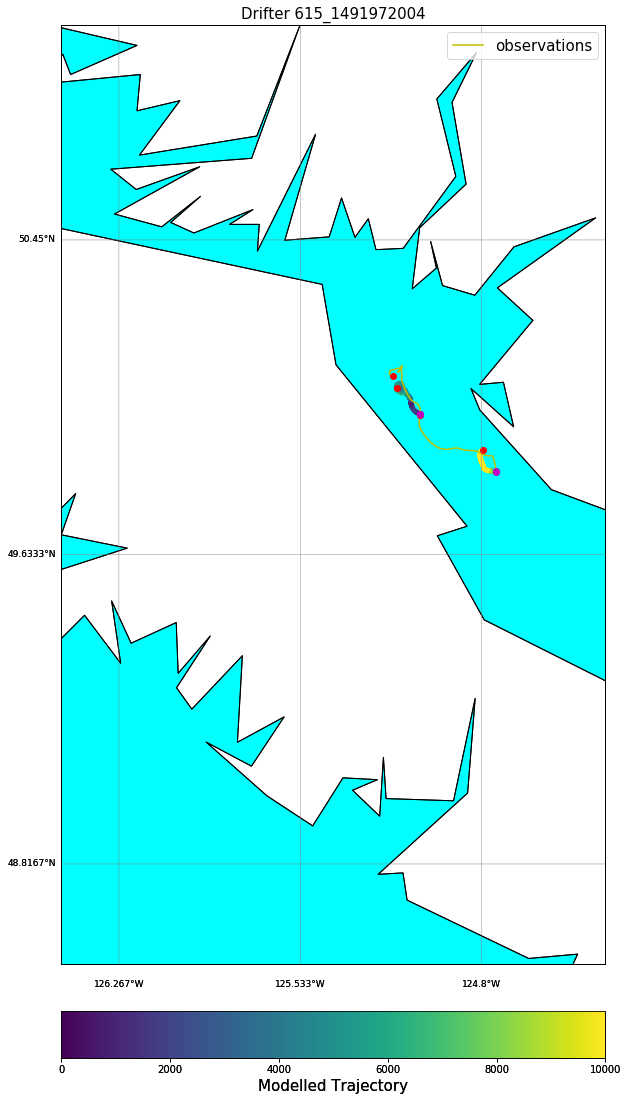

In [96]:
# select a file to plot from filelist
num = 5
fig, ax = plt.subplots(1,1)
map_features(12,16,20)
for file in filelist[num]:
    ds = xr.open_dataset(file)
    bbox = determine_latlon_bbox_for_drifters(ds)
maplot = Basemap(projection='merc',resolution='l',llcrnrlon=bbox.lon_min,llcrnrlat=bbox.lat_min,
                 urcrnrlon=bbox.lon_max,urcrnrlat=bbox.lat_max)    
for file in filelist[num]:
    plot_file(file,maplot,bbox)
    legends()
print('llon {} llat {} ulo {} ulat {}'.format(bbox.lon_min,bbox.lat_min,bbox.lon_max,bbox.lat_max))